# Chapter 19
## Recursive Filters

---



In [219]:
# Do I use all these? No idea, I just copied it from the last notebook
from math import sin, cos, pi, exp
import matplotlib.pyplot
# jupyter nbextension enable --py widgetsnbextension
from ipywidgets import interact, interactive, fixed, interact_manual
from numpy.fft import rfft, irfft
from numpy import absolute, arange, append, convolve, array_split
import numpy
import random

---

# Recursive Filters

* Also known as Infinite Impulse Response
  * Since impulse response composed of exponential decaying sinusoids (never reach 0)
* Filter carried out by use of a recursion equation
  * No convolution with a filter kernel
    * Potentially better performance
  * Remember moving average from a previous chapter?
  
  
* The recursion equation:
\begin{equation}
y[n] = a_0x[n] + a_1x[n-1] + a_2x[n-2] + ... \\
               ~~~~~~~~~~~~~~~~~~+ b_1y[n-1] + b_2y[n-2] + ...
\end{equation}
* Recursion coefficients
  * $a_n$ is for input samples
  * $b_n$ is for output samples
  * No $b_0$ above because it technically applies to currently calculated output
  * Don't use too many coefficients or output gets unstable


* The Z-transform (Chapter 33)
  * Convert recursion coefficients to frequency response
  * Combining cascaded and parallel stages
  * In other words, this is used to design recursive filters
  
---

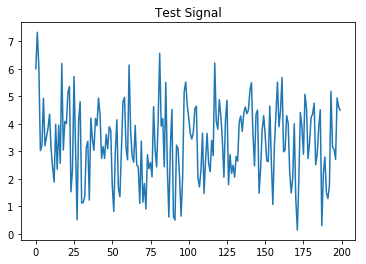

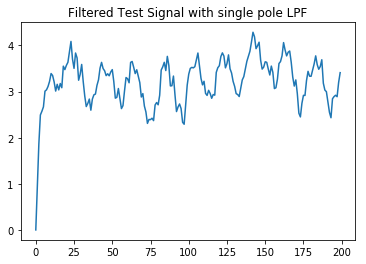

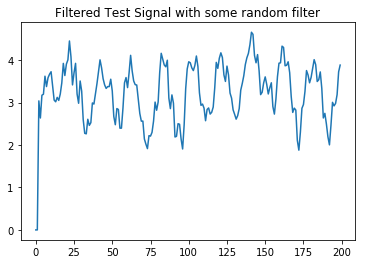

In [220]:
"""
Some signal we'll use to play with
"""
def some_signal():
    h = []
    M = 50
    random.seed(12)
    for i in arange(0,M,.25):
        a = sin(2*pi*i)
        b = exp(2*pi*1/(i+5))
        c = 2*pi*i/400
        d = cos(2*pi/5*i)
        e = random.random()*pi
        h.append(a+b+c+d+e)
    return h

"""
A simple single pole LPF
"""
def recursive_filter1(data, i=.15, o=.85):
    input_coeff = i
    output_coeff = o
    output = [0] # cuz we start at 1 below
    for i in range(1, len(data)):
        accum = 0
        accum += input_coeff * data[i-1]
        accum += output_coeff * output[i-1]
        output.append(accum)
    return output
        
"""
Some recursive filter
"""
def recursive_filter2(data):
    input_coeffs = [.15, .25, .05]
    output_coeffs = [.10, .45]
    # HPF coeffs below
    #input_coeffs = [.6, -.6, 0]
    #output_coeffs = [.20, 0]
    output = [0, 0] # cuz we start at 2 below
    for i in range(2, len(data)):
        accum = 0
        accum += input_coeffs[0] * data[i]
        accum += input_coeffs[1] * data[i-1]
        accum += input_coeffs[2] * data[i-2]
        accum += output_coeffs[0] * output[i-1]
        accum += output_coeffs[1] * output[i-2]
        output.append(accum)
    return output
        
"""
Plot and show data
"""
def plot_and_show(data, title="", xs = None):
    matplotlib.pyplot.title(title)
    if xs == None:
        matplotlib.pyplot.plot(data)
    else:
        matplotlib.pyplot.plot(xs, data)
    matplotlib.pyplot.show()

test_signal = some_signal()
filtered_signal = recursive_filter1(test_signal)
    
# Remove inline to get a sick ol' drag and droppable window
%matplotlib inline
plot_and_show(test_signal, "Test Signal")
plot_and_show(filtered_signal, "Filtered Test Signal with single pole LPF")
plot_and_show(recursive_filter2(test_signal), "Filtered Test Signal with some random filter")

---

## Single Pole Recursive Filters

* Single pole - Not really sure what this means in much detail yet, I hope it is explained later in the book
* Single pole recursive filters can be used like RC circuits in hardware:
  * HPF, wave shaping, DC removal, etc.


* Single Pole LPF:
\begin{equation}
a_0 = 1-x \\
b_1 = x \\
\textit{where x (between 0 and 1) is the amount of decay between adjacent samples}
\end{equation}


* Time constant of single pole filters:
\begin{equation}
x = e^{-1/d} \\
\textit{where x is decay, d is time constant} \\ 
\textit{(number of samples for filter to decay to 36.8%)}
\end{equation}
* If you want to contain as much of the impulse response as possible (with a single precision float) note that round off noise appears after about 15 to 20 time constants


* Cutoff frequency of single pole filters:
\begin{equation}
x = e^{-2\pi f_c} \\
\textit{where x is decay, $f_c$ is cutoff frequency from 0 to .5}
\end{equation}

---

In [221]:
"""
A simple single pole LPF
"""
def single_pole_LPF(data, x=0):
    input_coeff = 1-x
    output_coeff = x
    output = [0] # cuz we start at 1 below
    for i in range(1, len(data)):
        accum = 0
        accum += input_coeff * data[i-1]
        accum += output_coeff * output[i-1]
        output.append(accum)
    return output
        

def plot_LPF_with_fc(data, fc=0):
    # Plot original data
    plot_and_show(data, "original cruddy data")
    
    # Cutoff equation from above, where x is decay
    x = exp(-2*pi*fc)
    # Single pole LPF applied to data
    LPF_data = single_pole_LPF(data, x)
    plot_and_show(LPF_data, "LPF'd data")
    
    # And then also plot a frequency response
    impulse = [0]*100 + [1] + [0]*100
    impulse_resp = single_pole_LPF(impulse, x)
    freq_resp = absolute(rfft(impulse_resp)) # Polar magnitude
    # Just some x-values to plot for frequency scale
    x_vals = [i / (2*len(freq_resp)) for i in range(len(freq_resp))]
    plot_and_show(freq_resp, xs=x_vals, title="Frequency response of filter")

interact(plot_LPF_with_fc, data=fixed(test_signal), fc=(.01, .5, .01))
pass # stop using interact object as return value thing of ipython and printing "function blah de blah"
    

---

* Single Pole HPF:
\begin{equation}
a_0 = (1+x)/2 \\
a_1 = -(1+x)/2 \\
b_1 = x \\
\textit{where x (between 0 and 1) is the amount of decay between adjacent samples}
\end{equation}

---

In [222]:
"""
A simple single pole HPF
"""
def single_pole_HPF(data, x=0):
    input_coeff = [(1+x)/2, -(1+x)/2]
    output_coeff = x
    output = [0] # cuz we start at 1 below
    for i in range(1, len(data)):
        accum = 0
        accum += input_coeff[0] * data[i]
        accum += input_coeff[1] * data[i-1]
        accum += output_coeff * output[i-1]
        output.append(accum)
    return output
        

def plot_HPF_with_fc(data, fc=0):
    # Plot original data
    plot_and_show(data, "original cruddy data")
    
    # Cutoff equation from above, where x is decay
    x = exp(-2*pi*fc)
    # Single pole LPF applied to data
    HPF_data = single_pole_HPF(data, x)
    plot_and_show(HPF_data, "HPF'd data")
    
    # And then also plot a frequency response
    impulse = [0]*100 + [1] + [0]*100
    impulse_resp = single_pole_HPF(impulse, x)
    freq_resp = absolute(rfft(impulse_resp)) # Polar magnitude
    # Just some x-values to plot for frequency scale
    x_vals = [i / (2*len(freq_resp)) for i in range(len(freq_resp))]
    plot_and_show(freq_resp, xs=x_vals, title="Frequency response of filter")

interact(plot_HPF_with_fc, data=fixed(test_signal), fc=(.01, .5, .01))
pass # stop using interact object as return value thing of ipython and printing "function blah de blah"

---
### Single pole recursive filters

* As seen above the rolloff is terrible at higher values of $f_c$
* Single pole recursive filters are not good in frequency domain, but in time domain
* Can be _slightly_ improved by putting input back into filter multiple times
  * Rolloff is still bad
  * Better stopband attenuation

* Four stage LPF coefficients (found via Z-transform apparently)
\begin{equation}
a_0 = (1-x)^4 \\
b_1 = 4x \\
b_2 = -6x^2 \\
b_3 = 4x^3 \\
b_4 = -x^4 \\
\textit{where x (between 0 and 1) is the amount of decay between adjacent samples}
\end{equation}


* Cutoff frequency of above four stage filter:
\begin{equation}
x = e^{-14.445f_c} \\
\textit{where x is decay, $f_c$ is cutoff frequency from 0 to .5}
\end{equation}

---

In [223]:
"""
Four stage LPF
"""
# NOTE: Did I goof something up? 
#       The four stage is worse at higher fc values
def four_stage_LPF(data, x=0):
    input_coeff = (1-x)**4
    output_coeff = [4*x, -6*(x**2), 4*(x**3), -(x**4)]
    output = [0,0,0,0] # cuz we start at 4 below
    for i in range(4, len(data)):
        accum = 0
        accum += input_coeff * data[i]
        accum += output_coeff[0] * output[i-1]
        accum += output_coeff[1] * output[i-2]
        accum += output_coeff[2] * output[i-3]
        accum += output_coeff[3] * output[i-4]
        output.append(accum)
    return output
        
def plot_4LPF_with_fc(data, fc=0):  
    # Cutoff equation from WAY above for on stage filter
    x = exp(-2*pi*fc)
    # Single pole LPF applied to data
    LPF_data = single_pole_LPF(data, x)
    plot_and_show(LPF_data, "LPF'd data from 1 stage")
    
    # Cutoff equation from above for four stage filter
    x4 = exp(-14.445*pi*fc)
    # Single pole LPF applied to data
    LPF_data = four_stage_LPF(data, x4)
    plot_and_show(LPF_data, "LPF'd data from 4 stages")


interact(plot_4LPF_with_fc, data=fixed(test_signal), fc=(.01, .5, .01))
pass # stop using interact object as return value thing of ipython and printing "function blah de blah"

---

## Narrow-band Filters
* Narrow-band filters isolate a small band of frequencies from a signal
  * Band-pass filter
  * Band-reject filter (notch filter)

* BPF using recursion:
\begin{equation}
a_0 = (1-K) \\
a_1 = 2(K-R)cos(2\pi f) \\
a_2 = R^2 - K \\
b_1 = 2Rcos(2\pi f) \\
b_2 = -R^2 \\
\end{equation}


* BRF using recursion:
\begin{equation}
a_0 = K \\
a_1 = -2Kcos(2\pi f) \\
a_2 = K \\
b_1 = 2Rcos(2\pi f) \\
b_2 = -R^2 \\
\end{equation}

\begin{equation}
\textit{where} \\
K = \frac{1 - 2Rcos(2\pi f) + R^2}{2-2cos(2\pi f)} \\
R = 1 - 3BW \\
\textit{and where f (frequency) and BW (bandwidth) are from 0 to .5} \\
\textit{BW is measured at .707 amplitude}
\end{equation}

**Cheesus Crust that's a lot**

* Can see the large tails in below plots
  * Cascade stages to improve

---

In [224]:
"""
BPF via recursion
"""
def BPF(data, f, bw):
    R = 1 - 3*bw
    K = 1 - 2*R*cos(2*pi*f) + R**2
    K /= 2 - 2*cos(2*pi*f)
    
    input_coeff = [1-K, 2*(K-R)*cos(2*pi*f), R**2 - K]
    output_coeff = [2*R*cos(2*pi*f), -R**2]
    output = [0,0] # cuz we start at 2 below
    for i in range(2, len(data)):
        accum = 0
        accum += input_coeff[0] * data[i]
        accum += input_coeff[1] * data[i-1]
        accum += input_coeff[2] * data[i-2]
        accum += output_coeff[0] * output[i-1]
        accum += output_coeff[1] * output[i-2]
        output.append(accum)
    return output
        
def plot_BPF_with_fc(f=0, bw=0):
    data = [sin(2*pi*60*i)/10 + sin(2*pi*i) for i in arange(0,5,.01)]
    plot_and_show(data, "sin with noise")
    
    # Single pole LPF applied to data
    BPF_data = BPF(data, f, bw)
    plot_and_show(BPF_data, "BPF'd")
    
    # And then also plot a frequency response
    impulse = [0]*100 + [1] + [0]*100
    impulse_resp = BPF(impulse, f, bw)
    freq_resp = absolute(rfft(impulse_resp)) # Polar magnitude
    # Just some x-values to plot for frequency scale
    x_vals = [i / (2*len(freq_resp)) for i in range(len(freq_resp))]
    plot_and_show(freq_resp, xs=x_vals, title="Frequency response of filter")

interact(plot_BPF_with_fc, f=(.01, .5, .01), bw=(.01,.5,.01))
pass # stop using interact object as return value thing of ipython and printing "function blah de blah"

In [225]:
"""
BRJ via recursion
"""
def BRJ(data, f, bw):
    R = 1 - 3*bw
    K = 1 - 2*R*cos(2*pi*f) + R**2
    K /= 2 - 2*cos(2*pi*f)
    
    input_coeff = [K, -2*K*cos(2*pi*f), K]
    output_coeff = [2*R*cos(2*pi*f), -R**2]
    output = [0,0] # cuz we start at 2 below
    for i in range(2, len(data)):
        accum = 0
        accum += input_coeff[0] * data[i]
        accum += input_coeff[1] * data[i-1]
        accum += input_coeff[2] * data[i-2]
        accum += output_coeff[0] * output[i-1]
        accum += output_coeff[1] * output[i-2]
        output.append(accum)
    return output
        
def plot_BRJ_with_fc(f=0, bw=0):
    data = [sin(2*pi*60*i)/10 + sin(2*pi*i) for i in arange(0,5,.01)]
    plot_and_show(data, "sin with noise")
    
    # Single pole LPF applied to data
    BRJ_data = BRJ(data, f, bw)
    plot_and_show(BRJ_data, "Notched data")
    
    # And then also plot a frequency response
    impulse = [0]*100 + [1] + [0]*100
    impulse_resp = BRJ(impulse, f, bw)
    freq_resp = absolute(rfft(impulse_resp)) # Polar magnitude
    # Just some x-values to plot for frequency scale
    x_vals = [i / (2*len(freq_resp)) for i in range(len(freq_resp))]
    plot_and_show(freq_resp, xs=x_vals, title="Frequency response of filter")

interact(plot_BRJ_with_fc, f=(.01, .5, .01), bw=(.01,.5,.01))
pass # stop using interact object as return value thing of ipython and printing "function blah de blah"

---

## Phase Response


* **zero phase** - impulse response that is symmetric around sample 0
  * Phase from FFT is flat at 0
  
  
* **linear phase** - impulse response that is symmetric around some sample
  * Phase from FFT is a straight line with a non-zero slope (unless centered at sample 0)
  
  
* **nonlinear phase** - impulse response is not symmetric
  * Can make the pulse response of a filter goofy acting
    * EG: Right side is a sharp edge, left side is a gentle curve
    
   
* To deal with uneven step response, use **bidirectional filtering**:


0. Filter signal
0. Filter signal again moving from right to left
0. Combine filters via convolution in time domain


* Can reverse the filter by using reverse recursion equation:
\begin{equation}
y[n] = a_0x[n] + a_1x[n+1] + a_2x[n+2] + ... \\
               ~~~~~~~~~~~~~~~~~~+ b_1y[n+1] + b_2y[n+2] + ...
\end{equation}
or the convolution seems less difficult

---

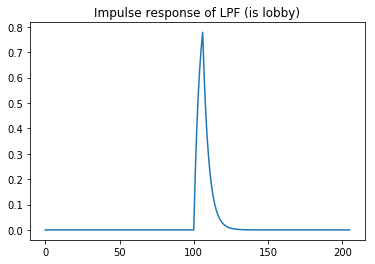

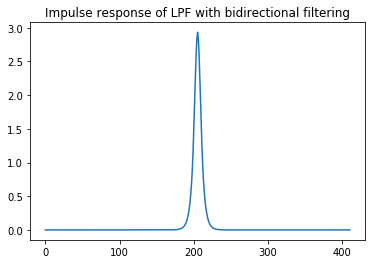

Note the amplitude is not the same


In [226]:

def plot_bidirectional_filtering():  
    # Cutoff equation from above, where x is decay
    fc = .04
    x = exp(-2*pi*fc)

    # LPF 
    impulse = [0]*100 + [1,1,1,1,1,1] + [0]*100
    impulse_resp = single_pole_LPF(impulse, x)
    #impulse_resp = [a+b for a,b in zip(impulse_resp, reversed(impulse_resp))]
    # Just some x-values to plot for frequency scale
    plot_and_show(impulse_resp, title="Impulse response of LPF (is lobby)")
    # Plot the bidirectional'd data
    bidir = convolve(impulse_resp, list(reversed(impulse_resp)))
    plot_and_show(bidir, "Impulse response of LPF with bidirectional filtering")

plot_bidirectional_filtering()
print("Note the amplitude is not the same")

---

### Isn't the above just correlation?

---

In [227]:
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
# buffer
